In [53]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, ElasticNet, Lasso
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.cross_validation import cross_val_score
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from scipy.stats import skew
from scipy.stats.stats import pearsonr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = 50
sns.set_style('darkgrid')
matplotlib.rc('font', size=20)
matplotlib.rc('axes', titlesize=20)
matplotlib.rc('axes', labelsize=20)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('figure', titlesize=20)
%matplotlib inline

In [54]:
train = pd.read_excel("train.xlsx")

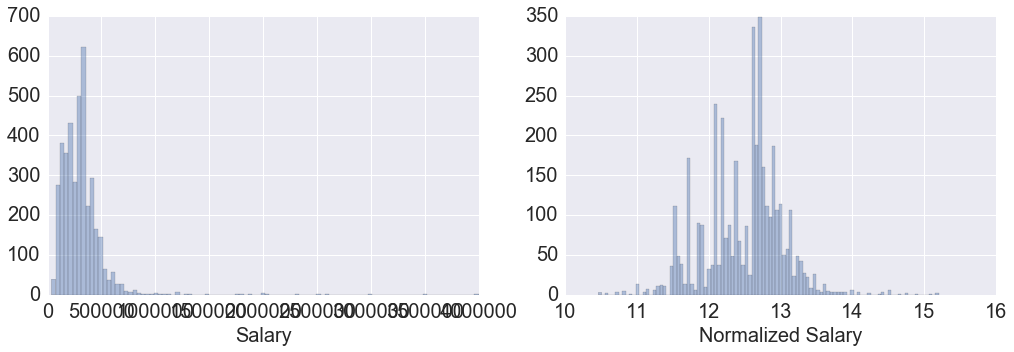

In [55]:
figure, (ax1,ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(train['Salary'], kde = False, ax = ax1, bins = 100)
sns.distplot(np.log1p(train["Salary"]), kde = False, axlabel = 'Normalized Salary', ax = ax2, bins = 100)

In [56]:
def convertTF(df,featureList):
    d = {True:1, False:0}
    for feature in featureList:
        df[feature] = df[feature].apply(lambda x: d[x])
    return df

def yearReturn(x):
    return x.year

def pos(x):
    if x > 0: 
        return 1
    else:
        return 0
def neg(x):
    if x < 0:
        return 1
    else:
        return 0

def val(x):
    if x > 0.44:
        return 3
    elif x < -0.44:
        return 1
    else:
        return 2

def conv_english(x) :
    if x >= 520:
        return 3
    elif x < 420:
        return 1
    else:
        return 2

def conv_logical(x) :
    if x >= 600:
        return 3
    elif x < 450:
        return 1
    else:
        return 2
    
def conv_quant(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def conv_prog(x) :
    if x >= 600:
        return 3
    elif x < 500:
        return 1
    else:
        return 2
    
def gpaCal(x):
    if x <= 10:
        return x*10
    else:
        return x
    
def isNationalBoard(row):
    if (row['isCbse'] or row['isISC'] or row['isICSE']):
        return 1
    else:
        return 0

def prepare(train):
    # Extract Designation
    train['isSenior'] = train.Designation.str.contains('senior')
    train['isSoftware'] = train.Designation.str.contains('software')
    train['isManager'] = train.Designation.str.contains('manager')
    train['isEngineer'] = train.Designation.str.contains('engineer')
    train['isDeveloper'] = train.Designation.str.contains('developer')
    
    # Extract Degree
    train['isBtech'] = train.Degree.str.contains('B.Tech/B.E.')
    train['isMCA'] = train.Degree.str.contains('MCA')
    train['isMtech'] = train.Degree.str.contains('M.Tech./M.E.')
    
    # Extract Board of Examination
    train['isCbse'] = train['12board'].str.contains('cbse')
    train['isStateBoard'] = train['12board'].str.contains('state board')
    train['isISC'] = train['12board'].str.contains('isc')
    train['isICSE'] = train['12board'].str.contains('icse')
    train['isCbse'].fillna(value = False, inplace = True)
    train['isStateBoard'].fillna(value = False, inplace = True)
    train['isISC'].fillna(value = False, inplace = True)
    train['isICSE'].fillna(value = False, inplace = True)
    train['isNationalBoard'] = 0
    train['isNationalBoard'] = train.apply(lambda x : isNationalBoard(x), axis=1)
    
    
    # Extract Specialization
    train['isCSE'] = train.Specialization.str.contains('computer engineering')
    train['isECE'] = train.Specialization.str.contains('electronics and communication engineering')
    train['isIT'] = train.Specialization.str.contains('information technology')
    train['isMech'] = train.Specialization.str.contains('mechanical engineering')
    train['isICE'] = train.Specialization.str.contains('instrumentation and control engineering')
    train['isEE'] = train.Specialization.str.contains('electrical engineering')
    
    train = convertTF(train, ['isCbse', 'isStateBoard', 'isISC', 'isICSE', 'isBtech', 'isMCA', 'isMtech', 'isSenior', 'isSoftware', 'isManager', 'isEngineer', 'isDeveloper','isCSE', 'isECE', 'isIT', 'isMech', 'isICE', 'isEE'])
    
    # Cleaning
    m = train.ComputerProgramming.mean(skipna=True)
    train.ComputerProgramming.fillna(m, inplace=True)

    n = train.Domain.mean(skipna=True)
    train.Domain.fillna(n, inplace=True)

    train.GraduationYear.replace(0,None,inplace=True)
    m = train.GraduationYear.mean(skipna=True)
    train.GraduationYear.fillna(m, inplace=True)
    
    # Generate Features

    #MaxDomain : max of the domains in one column
    train['maxDomain'] = train[['ComputerProgramming','ComputerScience','ElectronicsAndSemicon','MechanicalEngg','ElectricalEngg','TelecomEngg','CivilEngg']].max(axis=1)

    # diffGrad : difference between Graduation Year & 12th graduation, to see whether drop in college affect scores
    train['diffGrad'] = train.GraduationYear - train['12graduation']

    # diffGradDOB : difference between Graduation Year and DOB
    train['DOBY'] = train.DOB.apply(yearReturn)
    train['diffGradDOB'] = train.GraduationYear - train.DOBY
    
    # Big Five scores
    train['bigfive'] = 0
    train.bigfive += train.agreeableness.apply(lambda x : val(x))
    train.bigfive += train.conscientiousness.apply(lambda x : val(x))
    train.bigfive += train.nueroticism.apply(lambda x : val(x))
    train.bigfive += train.extraversion.apply(lambda x : val(x))
    train.bigfive += train.openess_to_experience.apply(lambda x : val(x))
    
    # Translate English / Logical / Quants scores
    train['scores'] = 0
    train['scores'] += train.English.apply(lambda x : conv_english(x))
    train['scores'] += train.Logical.apply(lambda x : conv_logical(x))
    train['scores'] += train.Quant.apply(lambda x : conv_quant(x))
    train['scores'] += train.ComputerProgramming.apply(lambda x : conv_prog(x))
    
    # Fix GPA to 100 scale
    train['mcolgGPA'] = train.collegeGPA.apply(lambda x: gpaCal(x))
    
    #Feature columns to take
    feature_cols = ['10percentage','12percentage', 'mcolgGPA', 'CollegeTier','CollegeCityTier', 'GraduationYear','scores','Domain','maxDomain','bigfive','diffGradDOB','isCSE','isIT','isECE','isMech','isICE','isEE']
    X = train[feature_cols]
    y = train.Salary
    
    return X,y

In [57]:
def display_metrics(model, y_test, y_pred, X_test):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("MSE : %f" % metrics.mean_squared_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ("Accuracy : %f" % model.score(X_test, y_test))
    print ("\n")

def model_train(model,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(model, y_test, y_pred, X_test)
    
def training(X,y):
    svm_clf = svm.SVR()
    print ("SVM Regression")
    model_train(svm_clf, X, y)

    rand_clf = RandomForestRegressor(n_estimators = 1500,max_features='sqrt')
    print ("Random Forests")
    model_train(rand_clf, X, y)

    linear_svm_clf = svm.LinearSVR()
    print ("Linear SVM Regression")
    model_train(linear_svm_clf, X, y)

    lasso_clf = linear_model.Lasso(alpha=0.01, selection="random", random_state=1)
    print ("Lasso Regression")
    model_train(lasso_clf, X, y)

    linear_clf = LinearRegression()
    print ("Linear Regression")
    model_train(linear_clf, X, y)

    
    return svm_clf, rand_clf, linear_svm_clf, lasso_clf, linear_clf


def testing(X, model, ds, file_name):
    y_pred = model.predict(X)
    submission = pd.DataFrame(columns=['ID','Salary'])
    submission.ID = ds.ID
    submission.Salary = y_pred

In [58]:
X, Y = prepare(train)

In [59]:
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X, Y, scoring="mean_squared_error", cv = 5))
    return(cve)

In [60]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("MSE : %f" % metrics.mean_squared_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print ("\n")

def model_train(model,X,y):
    # split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2 ,random_state = 42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
def training(X,y):
    
    #SVM Regression
    svm_clf = svm.SVR()
    print ("SVM Regression")
    model_train(svm_clf, X, y)
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_estimators = 1500,max_features='sqrt')
    print ("Random Forests")
    model_train(rand_clf, X, y)
    
    #Linear SVM Regression
    linear_svm_clf = svm.LinearSVR()
    print ("Linear SVM Regression")
    model_train(linear_svm_clf, X, y)
    
    #Lasso Regression
    lasso_clf = linear_model.Lasso(alpha=0.01, selection="random", random_state=1)
    print ("Lasso Regression")
    model_train(lasso_clf, X, y)
    
    #Linear Regression
    linear_clf = LinearRegression()
    print ("Linear Regression")
    model_train(linear_clf, X, y)

    
    return svm_clf, rand_clf, linear_svm_clf, lasso_clf, linear_clf

svm_clf, rand_clf, linear_svm_clf, lasso_clf, linear_clf = training(X, Y)



SVM Regression
MAE : 125660.975195
MSE : 53437907395.065865
RMSE : 231166.406286


Random Forests
MAE : 112047.853333
MSE : 48654837304.022224
RMSE : 220578.415318


Linear SVM Regression
MAE : 116568.714287
MSE : 51962867015.493454
RMSE : 227953.651025


Lasso Regression
MAE : 109570.991455
MSE : 47432422199.860603
RMSE : 217789.857890


Linear Regression
MAE : 109571.008486
MSE : 47432428255.495316
RMSE : 217789.871793




In [61]:
#Lasso
a_lasso = [1, 0.1, 0.001, 0.0005]
cvScores_lasso = [cv_error(Lasso(alpha = alpha)).mean() for alpha in a_lasso]
cvScores_lasso = pd.Series(cvScores_lasso, index = a_lasso)
minimum_error_lasso = cvScores_lasso.min()

//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metri

In [62]:
plt.figure(figsize=(20,15))
ax1.plot(cvScores_lasso)
ax1.set_title("Cross Validation (Lasso)")
ax1.set_xlabel("Regularization Parameter (alpha)")
ax1.set_ylabel("Error")
plt.show()

In [63]:
X.head()

10percentage  12percentage  mcolgGPA  CollegeTier  CollegeCityTier  \
train          84.3          95.8     78.00            2                0   
train          85.4          85.0     70.06            2                0   
train          85.0          68.2     70.00            2                0   
train          85.6          83.6     74.64            1                1   
train          78.0          76.8     73.90            2                0   

       GraduationYear  scores    Domain  maxDomain  bigfive  diffGradDOB  \
train            2011       7  0.635979        445       13           21   
train            2012      10  0.960603        466       11           23   
train            2014       7  0.450877        395       11           22   
train            2011      11  0.974396        615        9           22   
train            2012       8  0.124502        233        8           21   

       isCSE  isIT  isECE  isMech  isICE  isEE  
train      1     0      0       0      0     0  
train      0     0      1       0      0     0  
train      0     1      0       0      0     0  
train      1     0      0       0      0     0  
train      0     0      1       0      0     0

In [38]:
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X, Y, scoring="mean_squared_error", cv = 5))
    return(cve)


In [39]:
#Ridge
a_ridge = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cvScores_ridge = [cv_error(Ridge(alpha = alpha)).mean() for alpha in a_ridge]
cvScores_ridge = pd.Series(cvScores_ridge, index = a_ridge)
minimum_error = cvScores_ridge.min()

#Lasso
a_lasso = [1, 0.1, 0.001, 0.0005]
cvScores_lasso = [cv_error(Lasso(alpha = alpha)).mean() for alpha in a_lasso]
cvScores_lasso = pd.Series(cvScores_lasso, index = a_lasso)
minimum_error_lasso = cvScores_lasso.min()

#Plots
figure, (ax1, ax2) = plt.subplots(1,2,figsize = (17,5))
ax1.plot(cvScores_ridge)
ax1.set_title("Cross Validation (Ridge)")
ax1.set_xlabel("Regularization Parameter (alpha)")
ax1.set_ylabel("Error")
ax2.plot(cvScores_lasso)
ax2.set_title("Cross Validation (Lasso)")
ax2.set_xlabel("Regularization Parameter (alpha)")
ax2.set_ylabel("Error")

NameError: name 'Ridge' is not defined

In [64]:
train = pd.read_excel("train.xlsx")

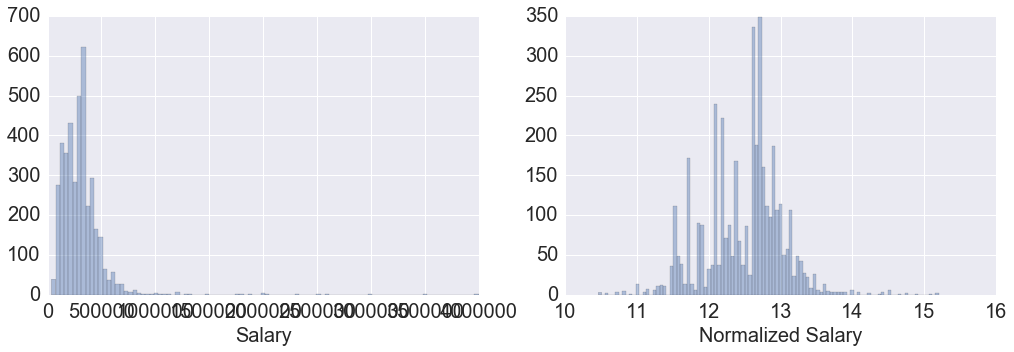

In [65]:
figure, (ax1,ax2) = plt.subplots(1,2,figsize = (17,5))
sns.distplot(train['Salary'], kde = False, ax = ax1, bins = 100)
sns.distplot(np.log1p(train["Salary"]), kde = False, axlabel = 'Normalized Salary', ax = ax2, bins = 100)
train.Salary = np.log1p(train.Salary)

In [80]:
X = train.drop('Salary', axis=1)
Y = train.Salary
X.head()

ID        DOJ                  DOL               Designation  \
train  203097 2012-06-01              present   senior quality engineer   
train  579905 2013-09-01              present         assistant manager   
train  810601 2014-06-01              present          systems engineer   
train  267447 2011-07-01              present  senior software engineer   
train  343523 2014-03-01  2015-03-01 00:00:00                       get   

         JobCity Gender        DOB  10percentage  \
train  Bangalore      f 1990-02-19          84.3   
train     Indore      m 1989-10-04          85.4   
train    Chennai      f 1992-08-03          85.0   
train    Gurgaon      m 1989-12-05          85.6   
train    Manesar      m 1991-02-27          78.0   

                              10board  12graduation  12percentage  \
train  board ofsecondary education,ap          2007          95.8   
train                            cbse          2007          85.0   
train                            cbse          2010          68.2   
train                            cbse          2007          83.6   
train                            cbse          2008          76.8   

                                  12board  CollegeID  CollegeTier  \
train  board of intermediate education,ap       1141            2   
train                                cbse       5807            2   
train                                cbse         64            2   
train                                cbse       6920            1   
train                                cbse      11368            2   

            Degree                             Specialization  collegeGPA  \
train  B.Tech/B.E.                       computer engineering       78.00   
train  B.Tech/B.E.  electronics and communication engineering       70.06   
train  B.Tech/B.E.                     information technology       70.00   
train  B.Tech/B.E.                       computer engineering       74.64   
train  B.Tech/B.E.  electronics and communication engineering       73.90   

       CollegeCityID  CollegeCityTier    CollegeState  GraduationYear  \
train           1141                0  Andhra Pradesh            2011   
train           5807                0  Madhya Pradesh            2012   
train             64                0   Uttar Pradesh            2014   
train           6920                1           Delhi            2011   
train          11368                0   Uttar Pradesh            2012   

       English  Logical  Quant    Domain  ComputerProgramming  \
train      515      585    525  0.635979                  445   
train      695      610    780  0.960603                   -1   
train      615      545    370  0.450877                  395   
train      635      585    625  0.974396                  615   
train      545      625    465  0.124502                   -1   

       ElectronicsAndSemicon  ComputerScience  MechanicalEngg  ElectricalEngg  \
train                     -1               -1              -1              -1   
train                    466               -1              -1              -1   
train                     -1               -1              -1              -1   
train                     -1               -1              -1              -1   
train                    233               -1              -1              -1   

       TelecomEngg  CivilEngg  conscientiousness  agreeableness  extraversion  \
train           -1         -1             0.9737         0.8128        0.5269   
train           -1         -1            -0.7335         0.3789        1.2396   
train           -1         -1             0.2718         1.7109        0.1637   
train           -1         -1             0.0464         0.3448       -0.3440   
train           -1         -1            -0.8810        -0.2793       -1.0697   

       nueroticism  openess_to_experience  
train      1.35490                -0.4455  
train     -0.10760                 0.8637  
train     -0.86820

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2 ,random_state = 1)
X_train.drop(['ID','DOJ','DOL','Designation','JobCity','CollegeCityID','DOB'], 1, inplace=True)
X_test.drop(['ID','DOJ','DOL','Designation','JobCity','CollegeCityID', 'DOB'], 1, inplace=True)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [85]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_test.head()

10percentage  12graduation  12percentage  CollegeID  CollegeTier  \
train          91.4          2007          86.0        250            1   
train          88.8          2010          80.0      12737            2   
train          91.0          2009          93.4        165            2   
train          80.0          2008          72.0        100            2   
train          68.2          2010          76.4         13            1   

       collegeGPA  CollegeCityTier  GraduationYear  English  Logical  Quant  \
train       90.24                0            2013      655      625    675   
train       76.00                1            2014      720      530    415   
train       81.20                1            2014      660      570    530   
train       62.00                0            2012      585      525    575   
train       69.00                1            2014      650      445    475   

         Domain  ComputerProgramming  ElectronicsAndSemicon  ComputerScience  \
train  0.974396                  615                     -1               -1   
train  0.486747                  435                     -1              376   
train  0.910770                   -1                    433               -1   
train  0.376060                  295                    300               -1   
train  0.649390                  435                    356              407   

       MechanicalEngg  ElectricalEngg  TelecomEngg  CivilEngg  \
train              -1              -1           -1         -1   
train              -1              -1           -1         -1   
train              -1              -1           -1         -1   
train              -1              -1          313         -1   
train              -1              -1           -1         -1   

       conscientiousness  agreeableness  extraversion  nueroticism  \
train            -1.0355         0.9688       -1.0697       0.1798   
train             0.4155        -0.2871       -0.4511      -0.8682   
train             0.2718         0.0459        0.7785      -1.5021   
train            -1.3447        -1.3713        0.0552      -0.0552   
train            -1.1644         0.2124       -0.2974       0.0192   

       openess_to_experience  Gender_f            ...             \
train                -0.6035       0.0            ...              
train                -0.6692       1.0            ...              
train                 0.4805       0.0            ...              
train                -0.2875       0.0            ...              
train                -1.0524       0.0            ...              

       Specialization_mechanical and automation  \
train                                       0.0   
train                                       0.0   
train                                       0.0   
train                                       0.0   
train                                       0.0   

       Specialization_mechanical engineering  Specialization_other  \
train                                    0.0                   0.0   
train                                    0.0                   0.0   
train                                    0.0                   0.0   
train                                    0.0                   0.0   
train                                    0.0                   0.0   

       CollegeState_Andhra Pradesh  CollegeState_Assam  CollegeState_Bihar  \
train                          0.0                 0.0                 0.0   
train                          0.0                 0.0                 0.0   
train                          0.0                 0.0                 0.0   
train                          0.0                 0.0                 0.0   
train                          0.0                 0.0                 0.0   

       CollegeState_Chhattisgarh  CollegeState_Delhi  CollegeState_Gujarat  \
train                        0.0                 0.0                   0.0   
train                     

In [94]:
def cv_error(model):
    cve= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="mean_squared_error", cv = 5))
    return(cve)

In [89]:
scaler = MinMaxScaler()
X_train= pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test= pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
X_test.head()

10percentage  12graduation  12percentage  CollegeID  CollegeTier  \
0      0.892319      0.666667      0.764797   0.013338          0.0   
1      0.843373      0.916667      0.649123   0.716079          1.0   
2      0.884789      0.833333      0.907461   0.008554          1.0   
3      0.677711      0.750000      0.494891   0.004896          1.0   
4      0.455572      0.916667      0.579719   0.000000          0.0   

   collegeGPA  CollegeCityTier  GraduationYear   English   Logical     Quant  \
0    0.910172              0.0        0.666667  0.708955  0.854167  0.714286   
1    0.753413              1.0        0.777778  0.805970  0.656250  0.360544   
2    0.810656              1.0        0.777778  0.716418  0.739583  0.517007   
3    0.599295              0.0        0.555556  0.604478  0.645833  0.578231   
4    0.676354              1.0        0.777778  0.701493  0.479167  0.442177   

     Domain  ComputerProgramming  ElectronicsAndSemicon  ComputerScience  \
0  0.987282             0.814815               0.000000         0.000000   
1  0.743437             0.576720               0.000000         0.550365   
2  0.955467             0.000000               0.707993         0.000000   
3  0.688089             0.391534               0.491028         0.000000   
4  0.824765             0.576720               0.582382         0.595620   

   MechanicalEngg  ElectricalEngg  TelecomEngg  CivilEngg  conscientiousness  \
0             0.0             0.0     0.000000        0.0           0.504933   
1             0.0             0.0     0.000000        0.0           0.741947   
2             0.0             0.0     0.000000        0.0           0.718474   
3             0.0             0.0     0.595825        0.0           0.454427   
4             0.0             0.0     0.000000        0.0           0.483878   

   agreeableness  extraversion  nueroticism  openess_to_experience  Gender_f  \
0       0.878226      0.483702     0.494588               0.751974       0.0   
1       0.714834      0.572294     0.302337               0.744678       1.0   
2       0.758157      0.748389     0.186051               0.872339       0.0   
3       0.573780      0.644803     0.451479               0.787062       0.0   
4       0.779819      0.594306     0.465127               0.702129       0.0   

             ...             Specialization_mechanical and automation  \
0            ...                                                  0.0   
1            ...                                                  0.0   
2            ...                                                  0.0   
3            ...                                                  0.0   
4            ...                                                  0.0   

   Specialization_mechanical engineering  Specialization_other  \
0                                    0.0                   0.0   
1                                    0.0                   0.0   
2                                    0.0                   0.0   
3                                    0.0                   0.0   
4                                    0.0                   0.0   

   CollegeState_Andhra Pradesh  CollegeState_Assam  CollegeState_Bihar  \
0                          0.0                 0.0                 0.0   
1                          0.0                 0.0                 0.0   
2                          0.0                 0.0                 0.0   
3                          0.0                 0.0                 0.0   
4                          0.0                 0.0                 0.0   

   CollegeState_Chhattisgarh  CollegeState_Delhi  CollegeState_Gujarat  \
0                        0.0                 0.0                   0.0   
1                        0.0                 0.0                   0.0   
2                        0.0                 0.0                   0.0   
3                        0.0                 0.0                   0.0   
4                        

In [91]:
X_train.drop(['12graduation','GraduationYear'],1,inplace=True)
X_test.drop(['12graduation','GraduationYear'],1,inplace=True)

In [93]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Columns: 623 entries, 10percentage to CollegeState_West Bengal
dtypes: float64(623)
memory usage: 15.2 MB


//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
//anaconda/lib/python3.5/site-packages/sklearn/metri

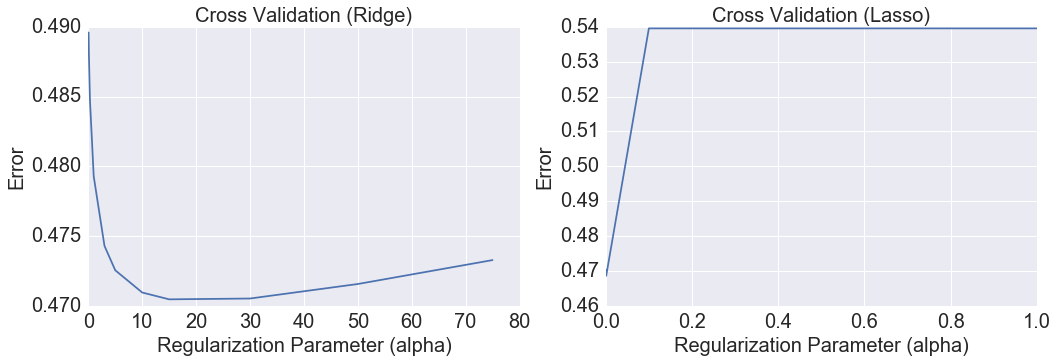

In [95]:
#Ridge
a_ridge = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cvScores_ridge = [cv_error(Ridge(alpha = alpha)).mean() for alpha in a_ridge]
cvScores_ridge = pd.Series(cvScores_ridge, index = a_ridge)
minimum_error = cvScores_ridge.min()

#Lasso
a_lasso = [1, 0.1, 0.001, 0.0005]
cvScores_lasso = [cv_error(Lasso(alpha = alpha)).mean() for alpha in a_lasso]
cvScores_lasso = pd.Series(cvScores_lasso, index = a_lasso)
minimum_error_lasso = cvScores_lasso.min()

#Plots
figure, (ax1, ax2) = plt.subplots(1,2,figsize = (17,5))
ax1.plot(cvScores_ridge)
ax1.set_title("Cross Validation (Ridge)")
ax1.set_xlabel("Regularization Parameter (alpha)")
ax1.set_ylabel("Error")
ax2.plot(cvScores_lasso)
ax2.set_title("Cross Validation (Lasso)")
ax2.set_xlabel("Regularization Parameter (alpha)")
ax2.set_ylabel("Error")

In [96]:
print("Minimum Error for Ridge Model: ", minimum_error)
print("Minimum Error for Lasso Model: ", minimum_error_lasso)

Minimum Error for Ridge Model:  0.470463056143
Minimum Error for Lasso Model:  0.468579744345


In [105]:
ridgeReg = Lasso(alpha=0.1)
ridgeReg.fit(X_train,y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [106]:
ridgeReg.score(X_train,y_train)

0.0